In [7]:
# Importing libraries
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geoplot as gplt 
import geopandas as gpd
import geoplot.crs as gcrs

In [23]:
# Data cleaning

#importing datasets needed
df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")
districts_df = gpd.read_file("../FinalDataStory/datasets/MO_MoDOT_Districts-20250502T153848Z-1-001/MO_MoDOT_Districts/MO_MoDOT_Districts.shp")

districts_df.head()
df.head()

#get list of columns to pick which ones i will need
col_names = df.columns.to_list()
#print(col_names)

#picking columns that i want
filtered_df = df[["OBJECTID", "STATE_CODE_001", "STRUCTURE_NUMBER_008", "COUNTY_CODE_003", "FACILITY_CARRIED_007"
                 , "LAT_016", "LONG_017", "YEAR_BUILT_027", "TRAFFIC_LANES_ON_028A", "ADT_029", "YEAR_ADT_030", 
                 "BRIDGE_IMP_COST_094", "YEAR_RECONSTRUCTED_106", "FUTURE_ADT_114", "YEAR_OF_FUTURE_ADT_115", 
                 "BRIDGE_CONDITION", "STRUCTURE_LEN_MT_049"]]

#filtered_df["YEAR_BUILT_027"] = pd.to_datetime(filtered_df["YEAR_BUILT_027"])

filtered_df.head()


C:\Users\macke\AppData\Local\Temp\ipykernel_10404\542453312.py:4: DtypeWarning: Columns (99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../FinalDataStory/datasets/NTAD_National_Bridge_Inventory_2178055625219331056.csv")


,OBJECTID,STATE_CODE_001,STRUCTURE_NUMBER_008,COUNTY_CODE_003,FACILITY_CARRIED_007,LAT_016,LONG_017,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,YEAR_ADT_030,BRIDGE_IMP_COST_094,YEAR_RECONSTRUCTED_106,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,BRIDGE_CONDITION,STRUCTURE_LEN_MT_049
0,290899,29,1,21,MO 6 E,39463723,94473709,1958,6,15423,2023,NaN,1992,20821,2043,F,61.6
1,290900,29,10,25,US 36 E,39440616,93562572,1958,4,8566,2023,NaN,2000,17989,2043,F,6.4
2,290901,29,100,165,IS 29 S,39273317,94471789,1958,4,36821,2023,204.0,0,75483,2043,P,6.6
3,290902,29,1000,77,US 60 E,37072768,93133368,1965,2,15996,2023,NaN,2009,24794,2043,F,120.4
4,290903,29,10000,67,MO 76 E,36581862,92254722,1940,2,419,2023,NaN,0,649,2043,F,15.5


YEAR_RECONSTRUCTED_106
1926     2
1929     3
1931     3
1932     4
1933     5
        ..
2020    55
2021    46
2022    38
2023    38
2024     5
Name: OBJECTID, Length: 92, dtype: int64


Text(0, 0.5, '# of bridges')

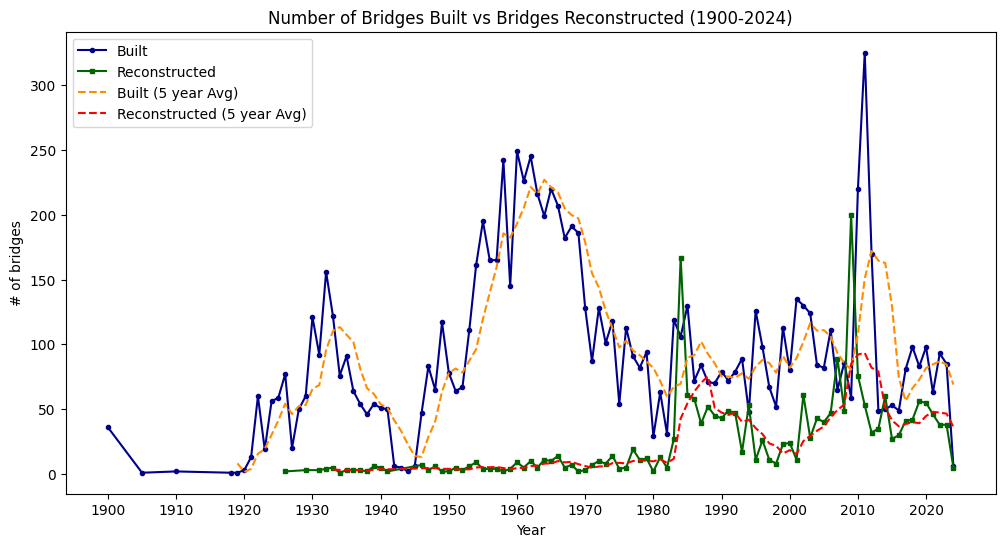

In [61]:
# Time series: Bridges built per year with bridges reconstructed per year

fig, ax = plt.subplots(figsize=(12,6))

#getting bridges and bridges reconstructed per year
bridges_per_year = filtered_df.groupby("YEAR_BUILT_027")["OBJECTID"].count()
reconst_per_year = filtered_df.groupby("YEAR_RECONSTRUCTED_106")["OBJECTID"].count()

#filtering out the first row (there are alot that have zeros = not reconstructed)
reconst_per_year = reconst_per_year.iloc[1:]
print(reconst_per_year)

#plotting
ax.plot(bridges_per_year.index, bridges_per_year.values, marker="o", ms=3, label="Built", color="darkblue")
ax.plot(reconst_per_year.index, reconst_per_year.values, marker="s", ms=3, label="Reconstructed", color="darkgreen")

#plotting rolling avgs for each dataset to be more descriptive
bridges_built_rolling = bridges_per_year.rolling(window=5).mean()
reconst_rolling = reconst_per_year.rolling(window=5).mean()
ax.plot(bridges_built_rolling.index, bridges_built_rolling.values, label="Built (5 year Avg)", linestyle="--", color="darkorange")
ax.plot(reconst_rolling.index, reconst_rolling.values, label="Reconstructed (5 year Avg)", linestyle="--", color="red")

#final touches
ax.set_xticks(np.arange(1900, 2025, 10)) #doing every 10 years instead of every 20
ax.set_title("Number of Bridges Built vs Bridges Reconstructed (1900-2024)")
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("# of bridges")

In [ ]:
# Pie chart: Number of bridges per district, Condition by district



In [ ]:
# Bar Chart: Top 5 highways with number of bridge mileage

